# Data Exploitation

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdflib import Graph, Namespace
from rdflib.plugins.sparql import prepareQuery
from typing import Iterable

In [43]:
g = Graph()
g.parse('data.ttl', format='turtle')
ont = Namespace("https://junjingw.github.io/bacteria-ontologia/ontology#")

## ARG-Pathogen Heatmap

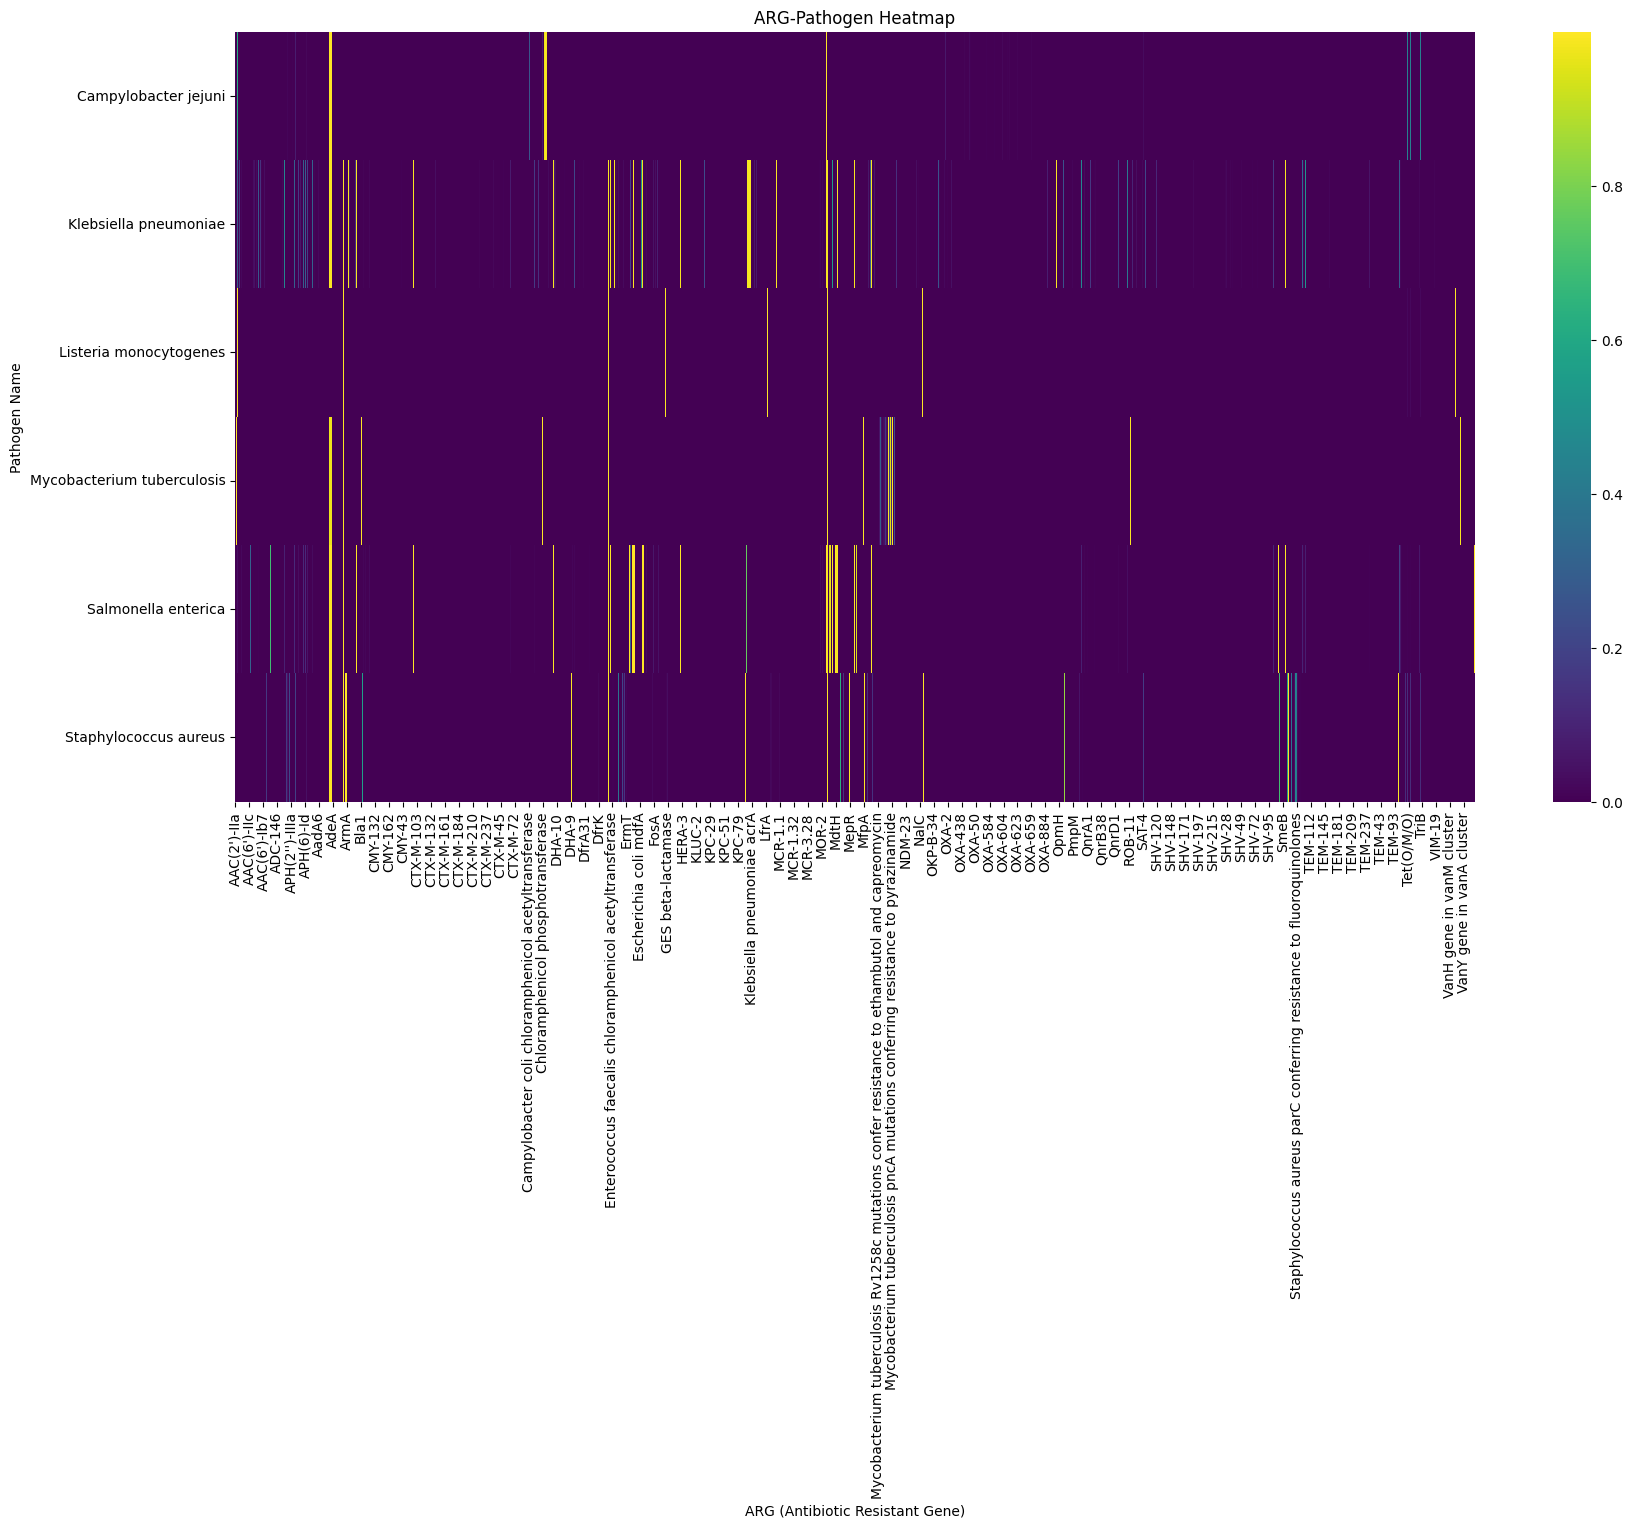

In [49]:
query_str = '''
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX ont: <https://junjingw.github.io/bacteria-ontologia/ontology#>

    SELECT 
        ?pathogen_name
        ?ARG_name
        ?frequency
    WHERE {
        ?bac a ont:Bacteria ;
            foaf:name ?pathogen_name ;
            ont:hasMutation ?mut .
        ?mut ont:linkedToARG ?arg ;
            ont:frequency ?frequency .
        ?arg foaf:name ?ARG_name .
    }
'''

query = prepareQuery(query_str, initNs={'ont': ont})

data = []
for r in g.query(query):
    data.append({
        'pathogen_name': r['pathogen_name'].value,
        'ARG_name': r['ARG_name'].value,
        'frequency': float(r['frequency'].value)
    })

# Create a DataFrame from the query results
df = pd.DataFrame(data)

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(index='pathogen_name', columns='ARG_name', values='frequency', fill_value=0)

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, cmap='viridis', annot=False)
plt.title('ARG-Pathogen Heatmap')
plt.xlabel('ARG (Antibiotic Resistant Gene)')
plt.ylabel('Pathogen Name')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Bacterias for a given ARG

{'Listeria monocytogenes': 0.019818, 'Staphylococcus aureus': 0.122228, 'Campylobacter jejuni': 0.437223}


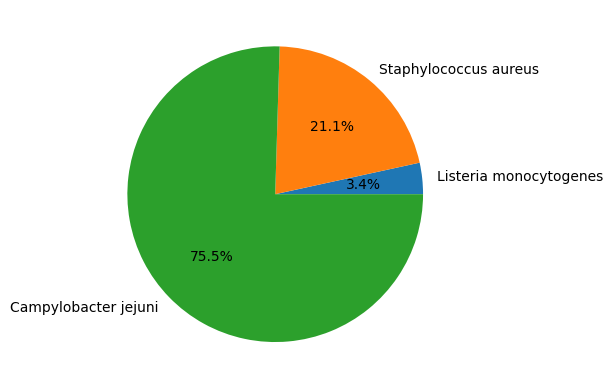

In [45]:
def bacterias_per_ARG(arg: str) -> dict[str, float]:
    query_str = f'''
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>

        SELECT 
            ?bacName
            ?freq
        WHERE{{
            ?arg foaf:name '{arg}' .
            ?mut ont:linkedToARG ?arg .
            ?mut ont:frequency ?freq .
            ?bac ont:hasMutation ?mut .
            ?bac foaf:name ?bacName
        }}
        ORDER BY ASC(?freq)'''
        
    query = prepareQuery(query_str,
        initNs = {'ont': ont}
    )

    data = {}
    for r in g.query(query):
        data[r['bacName'].value] = r['freq'].value
    return data

data = bacterias_per_ARG('Tet(O)')

if data:
    # Filter out small values
    threshold = max(data.values()) * 0.02
    filtered_data = {k: v for k, v in data.items() if v >= threshold}

    # Plot the pie chart with percentages
    print(filtered_data)
    pd.Series(filtered_data).plot.pie(autopct='%1.1f%%')
else:
    print('No data found for the given ARG.')

## Success Probability Given Symptoms

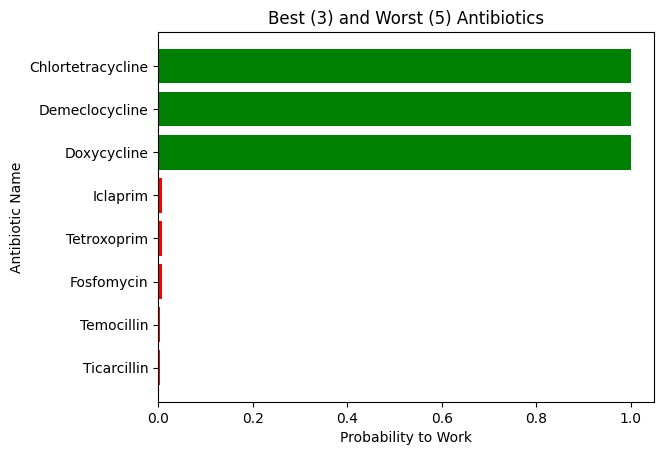

In [48]:
def antibiotic_success_rate(*symptoms: Iterable[str]) -> dict[str, float]:
    query_str = f'''
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>

        SELECT 
            DISTINCT ?ant_name 
            (1 - ?avg_freq AS ?probability_to_work)
        WHERE{{
            SELECT 
                ?ant_name
                (AVG(?freq) AS ?avg_freq)
            WHERE{{
                ?bacteria a ont:Bacteria ;
                    foaf:name ?name ;
                    ont:hasMutation ?mut ;
                    ont:hasSign {', '.join(f'"{symptom}"' for symptom in symptoms)} .
                       
                ?mut ont:linkedToARG ?arg ;
                    ont:frequency ?freq .
                ?arg foaf:name ?arg_name ;
                    ont:resistantTo ?ant .
                ?ant foaf:name ?ant_name
            }}
            GROUP BY ?ant_name
        }}
        ORDER BY DESC(?probability_to_work)'''
    query = prepareQuery(query_str, initNs={'ont': ont})
    
    data = {}
    for r in g.query(query):
        data[r['ant_name'].value] = r['probability_to_work'].value
    return data

antibiotic_data = antibiotic_success_rate('fever', 'cough')
antibiotic_series = pd.Series(antibiotic_data)
best_and_worst_antibiotics = pd.concat([antibiotic_series.head(3), antibiotic_series.tail(5)])

threshold = 0.8
colors = ['green' if value > threshold else 'red' for value in best_and_worst_antibiotics]

fig, ax = plt.subplots()
ax.barh(best_and_worst_antibiotics.index[::-1], best_and_worst_antibiotics.values[::-1], color=colors[::-1])
ax.set_xlabel('Probability to Work')
ax.set_ylabel('Antibiotic Name')
ax.set_title('Best (3) and Worst (5) Antibiotics');
# The probability assumes all bacteria are equally as likely to appear (we would need more data to calculate the actual probability)